In [9]:
import numpy as np
import xarray as xr
from minisom import MiniSom
import pandas as pd
from sklearn.preprocessing import RobustScaler
import pprint
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
from som_multivar_training import read_and_transform, build_scaler, train_som

# Example with 3 variables.

In [48]:
prefs= {'filename': '/home/z2034747/Research/Datasets/Combined/pwat_z500_td2m.nc',
        'vars': ['z500', 'td2m', 'pwat'], 'wlon': 220, 'elon': 305, 'nlat': 55, 'slat': 20, 
         'som_config': {'x': 3, 'y': 3, 'sigma': 1.5, 'random_seed': 42},
         'som_train': {'num_iteration': 20000, 'random_order': True, 'verbose': True}}

In [49]:
trained_som, trained_scaler, train_info, xr_data = train_som(prefs)

current model configuration
{'input_len': 36423, 'random_seed': 42, 'sigma': 1.5, 'x': 3, 'y': 3}
current training configuration
{'data': array([[-0.20787   , -0.23133911, -0.24382445, ..., -0.39776176,
        -0.19108878, -0.1742262 ],
       [-1.4184133 , -1.4353495 , -1.4344262 , ..., -1.1606435 ,
        -1.0643088 , -1.0463164 ],
       [ 0.2818785 ,  0.26043582,  0.24609436, ..., -1.0347401 ,
        -0.9122647 , -0.8908087 ],
       ...,
       [-0.37288073, -0.36255017, -0.34266713, ...,  0.16134287,
        -0.06155263, -0.45548353],
       [-0.9060967 , -0.880783  , -0.8457077 , ..., -0.27605513,
        -0.05695932, -0.07295413],
       [-0.7406267 , -0.7585039 , -0.7617178 , ..., -0.5390535 ,
        -0.5787782 , -0.5821934 ]], dtype=float32),
 'num_iteration': 20000,
 'random_order': True,
 'verbose': True}
 [ 20000 / 20000 ] 100% - 0:00:00 left 
 quantization error: 92.20592606121889


In [55]:
ds = xr.open_dataset('/home/z2034747/Research/Datasets/Combined/pwat_z500_td2m.nc')

In [ ]:
breaks = ds.sizes['lon'] * ds.sizes['lat']


win_map = trained_som.win_map(train_info['som_train']['data'])
node_keys = sorted(win_map.keys())

key1_avg_data = [
    np.reshape(
        trained_scaler.inverse_transform([np.mean(win_map[node], axis=0)])[0][:1 * breaks],
        (len(xr_data.lat), len(xr_data.lon))
    )
    for node in sorted(win_map.keys())
]


key2_avg_data = [
    np.reshape(
        trained_scaler.inverse_transform([np.mean(win_map[node], axis=0)])[0][1* breaks: 2* breaks],
        (len(xr_data.lat), len(xr_data.lon))
    )
    for node in sorted(win_map.keys())
]

key3_avg_data = [
    np.reshape(
        trained_scaler.inverse_transform([np.mean(win_map[node], axis=0)])[0][2* breaks: 3* breaks],
        (len(xr_data.lat), len(xr_data.lon))
    )
    for node in sorted(win_map.keys())
]

frequencies = trained_som.activation_response(train_info['som_train']['data']).flatten()


length, width = prefs['som_config']['x'], prefs['som_config']['y']

In [ ]:
np.sum(frequencies)

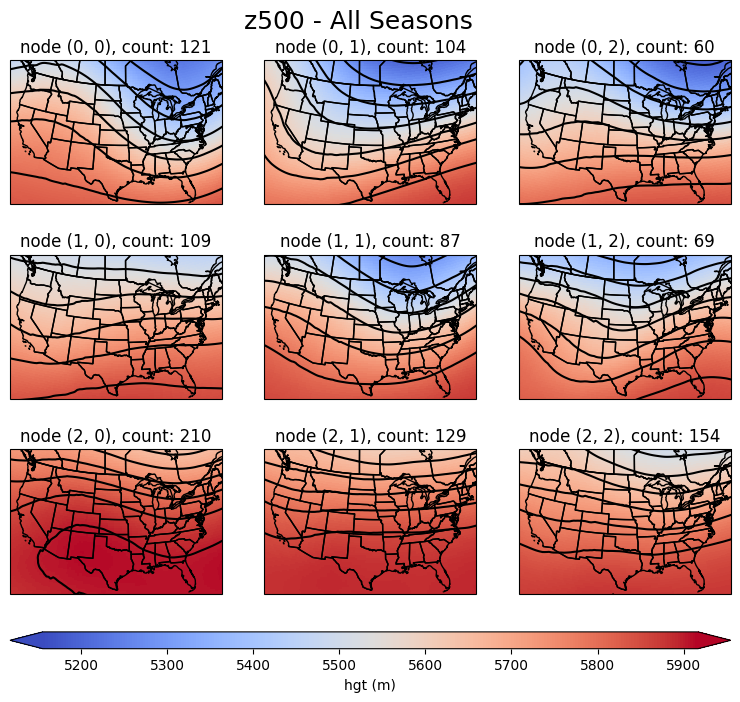

In [51]:
gs = GridSpec(nrows= length + 1, ncols= width, height_ratios=[1]*length + [0.1])
fig = plt.figure(figsize=(3.1 * length, 2.6 * width))
ax = [fig.add_subplot(gs[(x // length, x % width)], projection=ccrs.LambertConformal())
      for x in range(len(key1_avg_data))]
vmin = np.min(key1_avg_data)
vmax = np.max(key1_avg_data)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
for i, data in enumerate(key1_avg_data):
    ax[i].set_extent([xr_data.lon.values.min() - 340, xr_data.lon.values.max() - 380,
                      xr_data.lat.values.min() + 3, xr_data.lat.values.max() - 3])
    ax[i].add_feature(cfeature.BORDERS)
    ax[i].add_feature(cfeature.STATES)
    
    cf = ax[i].pcolormesh(xr_data.lon, xr_data.lat, data, cmap='coolwarm', norm= norm, transform=ccrs.PlateCarree())
    cn = ax[i].contour(xr_data.lon, xr_data.lat, data,  colors='k', transform=ccrs.PlateCarree())
    ax[i].set_title(f'node {node_keys[i]}, count: {int(frequencies[i])}')
    
    
cax = fig.add_subplot(gs[-1, :])    
fig.colorbar(cf, cax=cax, label='hgt (m)', extend= 'both', orientation='horizontal', aspect=0.8)
plt.suptitle('z500 - All Seasons', fontsize=18, y=0.93)
# plt.savefig('standard_anomalies.png', bbox_inches='tight')
plt.show()


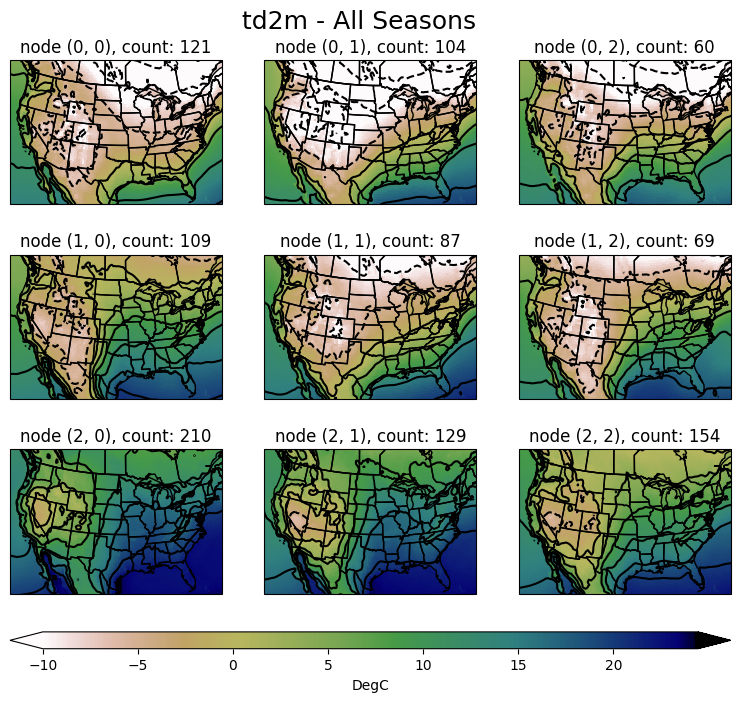

In [52]:
gs = GridSpec(nrows= length + 1, ncols= width, height_ratios=[1]*length + [0.1])
fig = plt.figure(figsize=(3.1 * length, 2.6 * width))
ax = [fig.add_subplot(gs[(x // length, x % width)], projection=ccrs.LambertConformal())
      for x in range(len(key2_avg_data))]
vmin = np.min(key2_avg_data)
vmax = np.max(key2_avg_data)
norm = mcolors.Normalize(vmin=-10, vmax=vmax)
for i, data in enumerate(key2_avg_data):
    ax[i].set_extent([xr_data.lon.values.min() - 340, xr_data.lon.values.max() - 380,
                      xr_data.lat.values.min() + 3, xr_data.lat.values.max() - 3])
    ax[i].add_feature(cfeature.BORDERS)
    ax[i].add_feature(cfeature.STATES)
    
    cf = ax[i].pcolormesh(xr_data.lon, xr_data.lat, data, cmap='gist_earth_r', norm= norm, transform=ccrs.PlateCarree())
    cn = ax[i].contour(xr_data.lon, xr_data.lat, data,  colors='k', transform=ccrs.PlateCarree())
    ax[i].set_title(f'node {node_keys[i]}, count: {int(frequencies[i])}')
    
    
cax = fig.add_subplot(gs[-1, :])    
fig.colorbar(cf, cax=cax, label='DegC', extend= 'both', orientation='horizontal', aspect=0.8)
plt.suptitle('td2m - All Seasons', fontsize=18, y=0.93)
# plt.savefig('standard_anomalies.png', bbox_inches='tight')
plt.show()


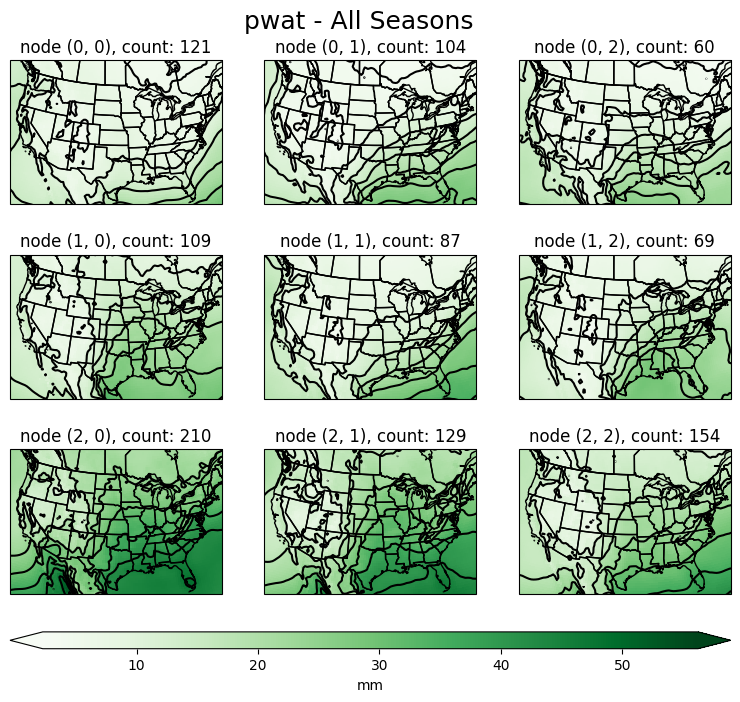

In [53]:
gs = GridSpec(nrows= length + 1, ncols= width, height_ratios=[1]*length + [0.1])
fig = plt.figure(figsize=(3.1 * length, 2.6 * width))
ax = [fig.add_subplot(gs[(x // length, x % width)], projection=ccrs.LambertConformal())
      for x in range(len(key3_avg_data))]
vmin = np.min(key3_avg_data)
vmax = np.max(key3_avg_data)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
for i, data in enumerate(key3_avg_data):
    ax[i].set_extent([xr_data.lon.values.min() - 340, xr_data.lon.values.max() - 380,
                      xr_data.lat.values.min() + 3, xr_data.lat.values.max() - 3])
    ax[i].add_feature(cfeature.BORDERS)
    ax[i].add_feature(cfeature.STATES)
    
    cf = ax[i].pcolormesh(xr_data.lon, xr_data.lat, data, cmap='Greens', norm= norm, transform=ccrs.PlateCarree())
    cn = ax[i].contour(xr_data.lon, xr_data.lat, data,  colors='k', transform=ccrs.PlateCarree())
    ax[i].set_title(f'node {node_keys[i]}, count: {int(frequencies[i])}')
    
    
cax = fig.add_subplot(gs[-1, :])    
fig.colorbar(cf, cax=cax, label='mm', extend= 'both', orientation='horizontal', aspect=0.8)
plt.suptitle('pwat - All Seasons', fontsize=18, y=0.93)
# plt.savefig('standard_anomalies.png', bbox_inches='tight')
plt.show()


In [56]:
ds

<xarray.Dataset> Size: 152MB
Dimensions:  (time: 1043, lat: 71, lon: 171)
Coordinates:
  * time     (time) datetime64[ns] 8kB 2000-01-05 2000-01-12 ... 2019-12-25
  * lat      (lat) float32 284B 55.0 54.5 54.0 53.5 53.0 ... 21.5 21.0 20.5 20.0
  * lon      (lon) float32 684B 220.0 220.5 221.0 221.5 ... 304.0 304.5 305.0
Data variables:
    pwat     (time, lat, lon) float32 51MB ...
    td2m     (time, lat, lon) float32 51MB ...
    z500     (time, lat, lon) float32 51MB ...

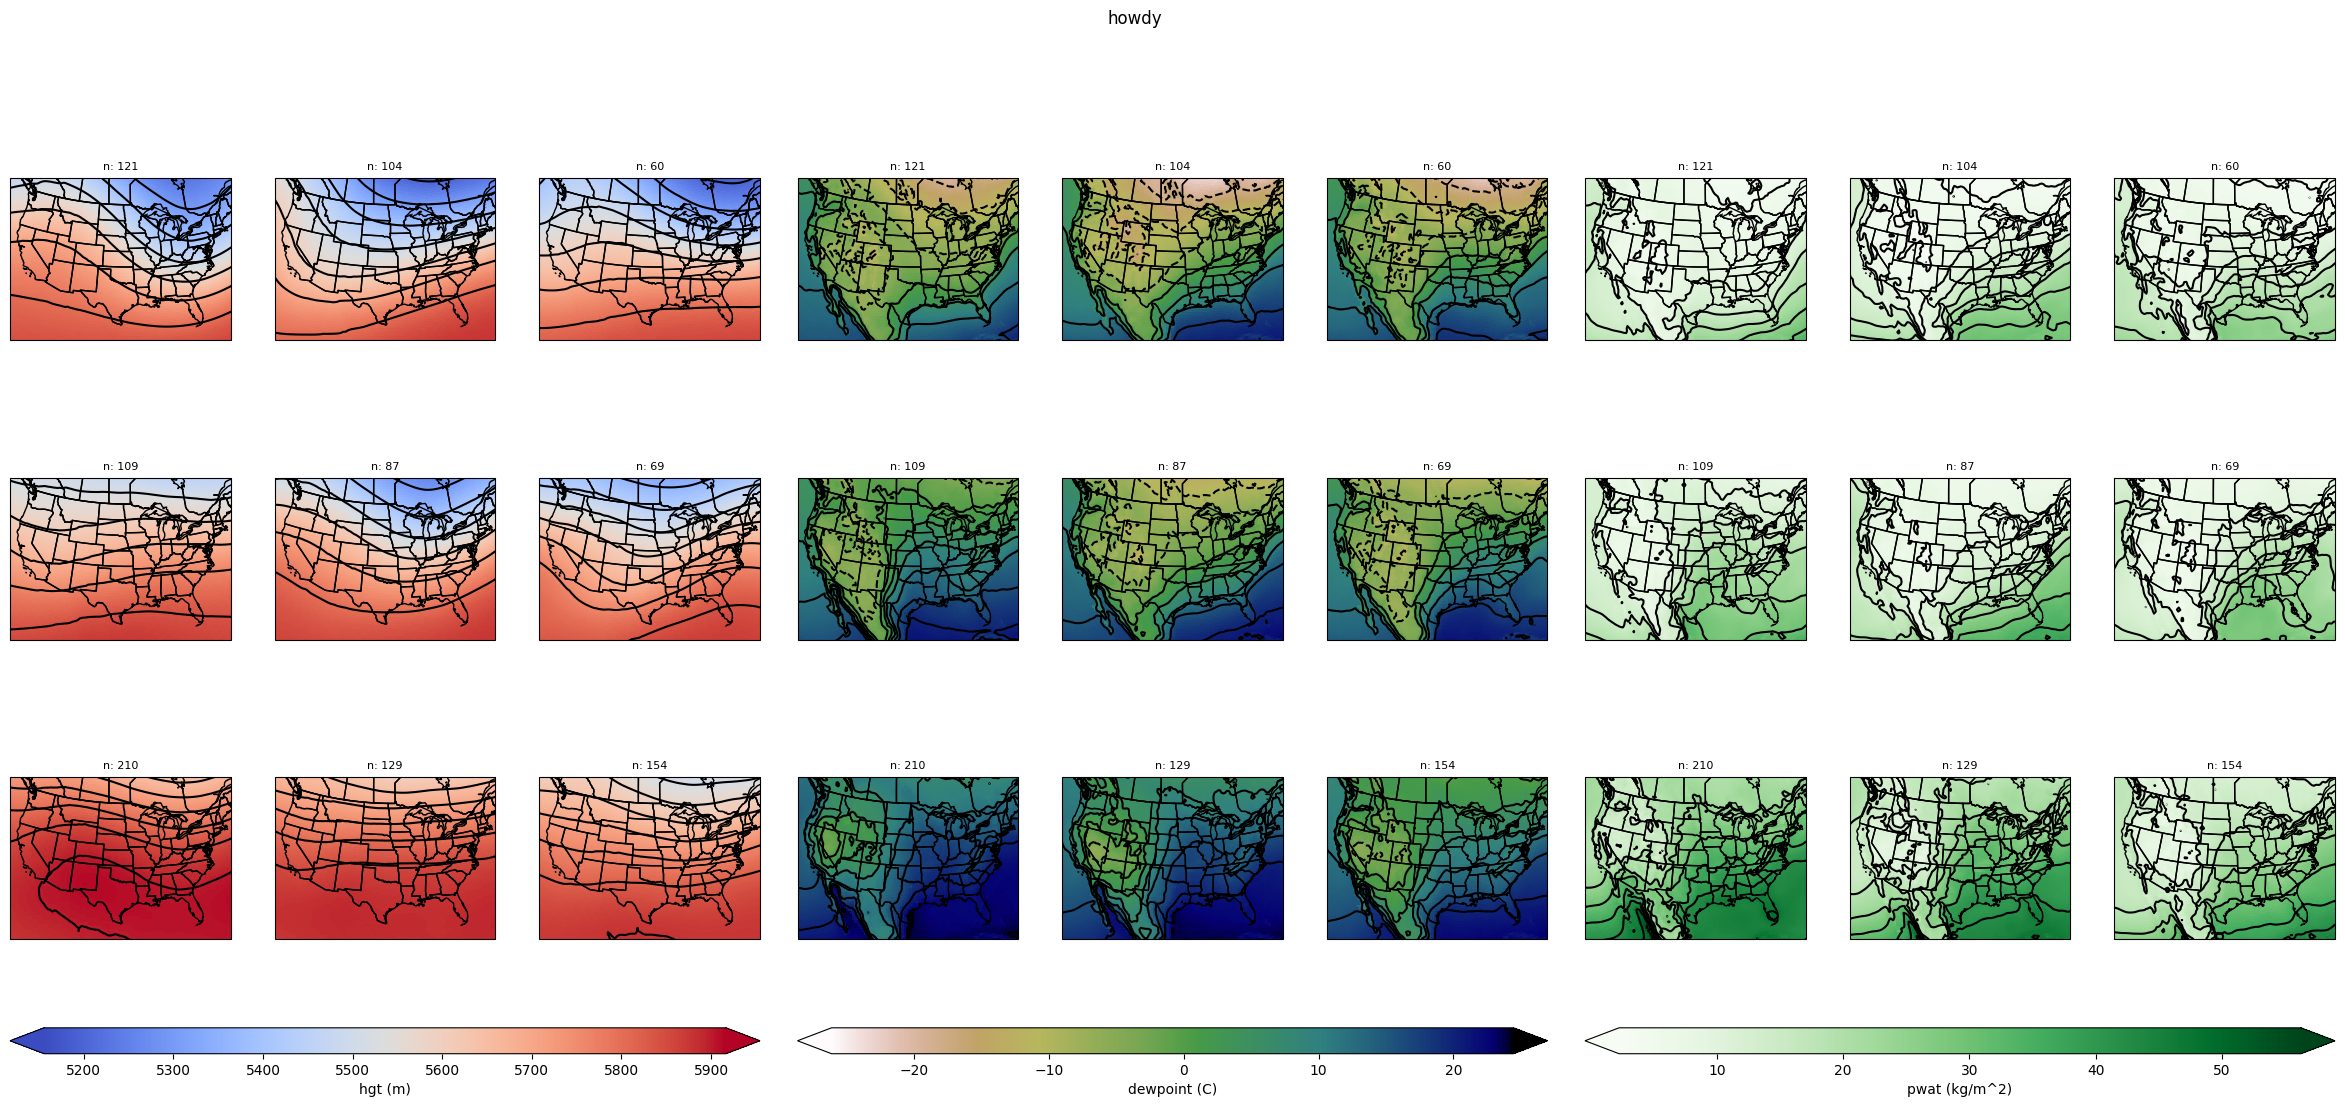

In [70]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors

# Group your data and metadata for the loop
all_vars_data = [key1_avg_data, key2_avg_data, key3_avg_data]
all_titles = ['z500 - All Seasons', 'td2m - All Seasons', 'pwat - All Seasons']
all_labels = ['hgt (m)', 'dewpoint (C)', 'pwat (kg/m^2)']
cmaps = ['coolwarm', 'gist_earth_r', 'Greens']
    

# Total figure: 3 columns (one per variable)
fig = plt.figure(figsize=(30, 12)) # Adjust width/height as needed for 3x3
outer_gs = gridspec.GridSpec(1, 3, wspace=0.05) 

for v_idx, key_avg_data in enumerate(all_vars_data):
    # Create a sub-gridspec for this specific variable's 3x3 grid
    # nrows = length + 1 (for colorbar), ncols = width
    inner_gs = gridspec.GridSpecFromSubplotSpec(nrows=length + 1, ncols=width, 
                                                subplot_spec=outer_gs[v_idx], 
                                                height_ratios=[1]*length + [0.1])
    
    vmin = np.min(key_avg_data)
    vmax = np.max(key_avg_data)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    # Draw the 3x3 nodes for this variable
    for i, data in enumerate(key_avg_data):
        ax = fig.add_subplot(inner_gs[(i // width, i % width)], projection=ccrs.LambertConformal())
        
        ax.set_extent([xr_data.lon.values.min() - 340, xr_data.lon.values.max() - 380,
                          xr_data.lat.values.min() + 3, xr_data.lat.values.max() - 3], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES)
        
        cf = ax.pcolormesh(xr_data.lon, xr_data.lat, data, cmap= cmaps[v_idx], norm=norm, transform=ccrs.PlateCarree())
        cn = ax.contour(xr_data.lon, xr_data.lat, data, colors='k', transform=ccrs.PlateCarree())
        
        # Only set titles on the top row of each sub-grid to keep it clean
        ax.set_title(f'n: {int(frequencies[i])}', fontsize=8)

    # Add the colorbar for this specific variable at the bottom of its 3x3 grid
    cax = fig.add_subplot(inner_gs[-1, :])    
    fig.colorbar(cf, cax=cax, label=all_labels[v_idx], extend='both', orientation='horizontal', aspect=0.8)
plt.suptitle('hi', x= -5)
plt.suptitle('hello', x = 0)
plt.suptitle('howdy', x = 0.5)
    
# plt.savefig('three_vars.png', dpi= 300, bbox_inches= 'tight')
plt.show()

